# import package

In [92]:
import imutils, cv2 
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\jonathan.calmus\AppData\Local\Tesseract-OCR\tesseract.exe'
import tiffcapture as tc
import numpy as np
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression
%matplotlib notebook

# Preprocessing for Tesseract

In [2]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

# load image

In [11]:
img = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
imS = cv2.resize(img, (1200, 800)) 
cv2.imshow('img', imS)
cv2.waitKey(0)
# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

"i\n{ ae\n{\nThis form is dated 1 March 2013 and is valid until 28 February 2014 |\nLife Insured’s 7 ae :\nStatement | ZURICH\n|\nPlease fill out a separate Lite tisured’s Statement for each 3.04 Have you applied for permanent residency? . to\ninsured life, The Life insured’s statement starts on this C) Yes go to4 “\npage and ends on page 27. . { ‘ .\n° (3 No > Do you intend to apply?\n‘ : ©) Yes\n1. underwriting pre-assessment 0 No\nHas an underwriting pre-assessment been provided for . .\nthis application? — 4. current occupation\ntJ No > goto2 ° 4.01 What is your current occupation and industry?\nld Yes > provide details current occupation ‘on db / \\\ndate of pre-assessment / / oo cecruutntimens vs unsamaaml C3 ntall Thou bt renee |\n—— 3 a!\n| name of underwriter Le i . current company/employer name Mi ' =!\n| . . industry ‘\nee poten Kechag. a a ¥ sa © ane 2.\nAttach a copy of the pre-assessment advice. 4.02 Are any of your duties hazardous?\n‘ These include but are not limited t

In [13]:
#pytesseract.image_to_data(img, output_type=Output.DICT)

In [25]:
gray = get_grayscale(img)
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [27]:
img = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

imS = cv2.resize(img, (1200, 800)) 
cv2.imshow('img', imS)
cv2.waitKey(0)

-1

In [6]:
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [28]:
img = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['text'])
print(n_boxes)
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

imS = cv2.resize(img, (1200, 800)) 
cv2.imshow('img', imS)
cv2.waitKey(0)

549


-1

# To find a word

In [23]:
overlay = img.copy()
for i in range(n_boxes):
    text = d['text'][i]
    if text == 'underwriting':
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        (x1, y1, w1, h1) = (d['left'][i + 1], d['top'][i + 1], d['width'][i + 1], d['height'][i + 1])
        (x2, y2, w2, h2) = (d['left'][i + 2], d['top'][i + 2], d['width'][i + 2], d['height'][i + 2])
        # cv2.rectangle(img, (x, y), (x1 + w1, y1 + h1), (0, 255, 0), 2)
        cv2.rectangle(overlay, (x, y), (x1 + w1, y1 + h1), (255, 0, 0), -1)
        # cv2.rectangle(img, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 2)
        cv2.rectangle(overlay, (x2, y2), (x2 + w2, y2 + h2), (0, 0, 255), -1)
        # print(text)
alpha = 0.4  # Transparency factor.
# Following line overlays transparent rectangle over the image
img_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
r = 550.0 / img_new.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(img_new.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(img_new, dim, interpolation=cv2.INTER_AREA)
cv2.imshow('img', resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

# multiframe

In [29]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
img=img[1]
imS = cv2.resize(img, (1200, 800)) 
cv2.imshow('img', imS)
cv2.waitKey(0)
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['text'])
print(n_boxes)

750


In [30]:
overlay = img.copy()
for i in range(n_boxes):
    text = d['text'][i]
    if text == 'Self':
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        (x1, y1, w1, h1) = (d['left'][i + 1], d['top'][i + 1], d['width'][i + 1], d['height'][i + 1])
        (x2, y2, w2, h2) = (d['left'][i + 2], d['top'][i + 2], d['width'][i + 2], d['height'][i + 2])
        cv2.rectangle(overlay, (x, y), (x1 + w1, y1 + h1), (255, 0, 0), -1)
        cv2.rectangle(overlay, (x2, y2), (x2 + w2, y2 + h2), (0, 0, 255), -1)
        print(text)
alpha = 0.4  # Transparency factor.
# Following line overlays transparent rectangle over the image
img_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
r = 550.0 / img_new.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(img_new.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(img_new, dim, interpolation=cv2.INTER_AREA)
cv2.imshow('img', resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Self


In [31]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

'oe BS - T\n’ 1\nLife Insured’s Statement\nops Do you work from home? 6.14 Are you applying for Income replacement cover, or\n. No > go to 6.06 \' Business expenses cover?\n(C) Yes > pravide details of your home business set-up (Ne > go ta7\n‘ iM Yes > complete questions below !\nes tie oe eet , 6.1 Do you have any sick leave entitlements?\n"hours working at home per week \' hours (3 No 3 go to 6.16\n“ ” a ~~ (1) Yes > provide details .\nAre these hours included in the hours worked in 6.04? : .\ndays per annum total accumulated sick days\nQO No L \\ |\nO Yes ee\n6.06 What duties do you perform? 6.16/Do you receive income from other sources?\ninclude the percentage of time spent performing each (ey/avidend)\nduty % ot time w No go to 6.17 1\n‘ . (.) Yes > provide details \'\noceans ieaneeeceeanar mune tins oe seneuilaweneeteteniuesueannns ts nes tafser eon  SOUrCe Of INCOME amount per annum\nce camntiiietieucunmcnsettegsaims Hunts bane e casanians Oo oka cue canine caer cae cosas aviere

In [40]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'

retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
img=img[1]
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d)
n_boxes = len(d['text'])
print(n_boxes)
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

imS = cv2.resize(img, (1200, 800)) 
cv2.imshow('img', imS)
cv2.waitKey(0)

{'level': [1, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5,

-1

In [41]:
d["text"]

['',
 '',
 '',
 '',
 'Life',
 'Insured’s',
 'Statement',
 '',
 '',
 '',
 'ops',
 'Do',
 'you',
 'work',
 'from',
 'home?',
 '',
 'No',
 '>',
 'go',
 'to',
 '6.06',
 '',
 '',
 '',
 'C)',
 'Yes',
 '>',
 'provide',
 'details',
 'of',
 'your',
 'home',
 'business',
 'set-up',
 '',
 '',
 '',
 ' ',
 ' ',
 '',
 '',
 '',
 '“hours',
 'working',
 'at',
 'home',
 'per',
 'week',
 '',
 '',
 '',
 'hours',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 'Are',
 'these',
 'hours',
 'included',
 'in',
 'the',
 'hours',
 'worked',
 'in',
 '6.04?',
 '',
 'QO',
 'No',
 '',
 'a)',
 'Yes',
 '',
 '',
 '',
 '6,06',
 'What',
 'duties',
 'do',
 'you',
 'perform?',
 '',
 'include',
 'the',
 'percentage',
 'of',
 'time',
 'spent',
 'performing',
 'each',
 '',
 '',
 '',
 'duty',
 '%',
 'ot',
 'time',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '6.07',
 'Do',
 'you',
 'perform',
 'any',
 'manual',
 'labour?',
 '',
 '',
 '',
 'ye',
 '>',
 'go',
 'to',
 '6.08',
 '',
 'Yes',
 '>',
 'indicate',
 'the',
 'percentage

# checkbox

In [4]:
original_image = cv2.imread("03539292.tif")
image = original_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 120, 255, 1)

r = 550.0 / edged.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(edged.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(edged, dim, interpolation=cv2.INTER_AREA)
cv2.imshow("edged", resized)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

checkbox_contours = []

threshold_max_area = 250
threshold_min_area = 200
contour_image = edged.copy()

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.035 * peri, True)
    (x, y, w, h) = cv2.boundingRect(approx)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(c) 
    if area < threshold_max_area and area > threshold_min_area and (aspect_ratio >= 0.9 and aspect_ratio <= 1.1):
        cv2.drawContours(original_image,[c], 0, (0,255,0), 3)
        checkbox_contours.append(c)

print('checkbox_contours', len(checkbox_contours))
r = 550.0 / original_image.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(original_image.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(original_image, dim, interpolation=cv2.INTER_AREA)
cv2.imshow("checkboxes", resized)
cv2.waitKey(0)

checkbox_contours 62


-1

In [20]:
# Load image, convert to grayscale, Otsu's threshold
image = cv2.imread("03539292.tif")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, filter using contour approximation, aspect ratio, and contour area
threshold_max_area = 550
threshold_min_area = 100
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.035 * peri, True)
    x,y,w,h = cv2.boundingRect(approx)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(c) 
#    if len(approx) == 4 and area < threshold_max_area and area > threshold_min_area and (aspect_ratio >= 0.9 and aspect_ratio <= 1.1):
#        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    if area < threshold_max_area and area > threshold_min_area and (aspect_ratio >= 0.9 and aspect_ratio <= 1.1):
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

r = 550.0 / image.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(image.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
cv2.imshow("image", resized)
r = 550.0 / thresh.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(thresh.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(thresh, dim, interpolation=cv2.INTER_AREA)
cv2.imshow("thresh", resized)
cv2.waitKey()

-1

In [47]:
# Load image, convert to grayscale, Otsu's threshold
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bw = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
contours,hierarchy=cv2.findContours(bw, cv2.RETR_CCOMP, 1)
cntlen=10
ct=0
for cnt in contours:
    if len(cnt)>cntlen:
            ct+=1
            newing=img.copy()
            cv2.drawContours(newing,[cnt], 0, (0,0,255), 2)
r = 550.0 / newing.shape[1]  # resizing image without loosing aspect ratio
dim = (550, int(newing.shape[0] * r))
# perform the actual resizing of the image and show it
resized = cv2.resize(newing, dim, interpolation=cv2.INTER_AREA)
cv2.imshow("image", resized)
cv2.waitKey(0)

-1

# opencv

<IPython.core.display.Javascript object>


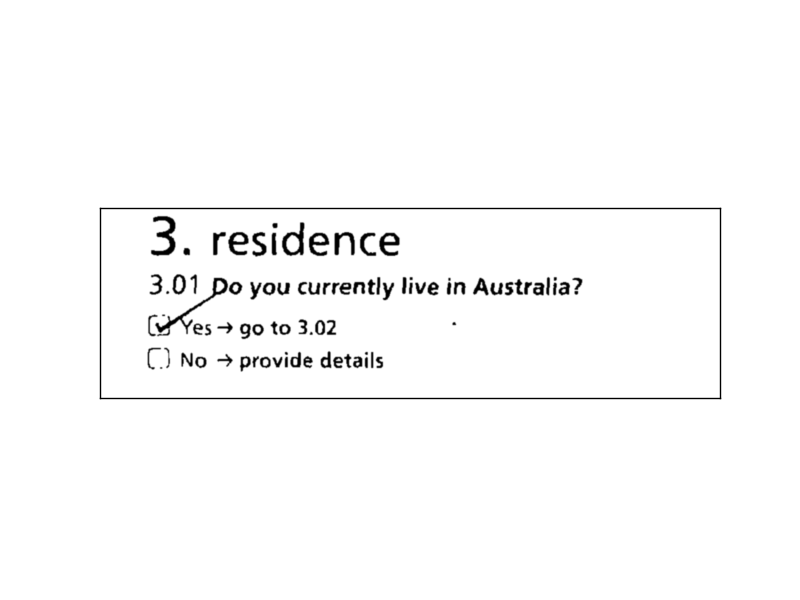

In [14]:
img = cv2.imread('03539292.tif',0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


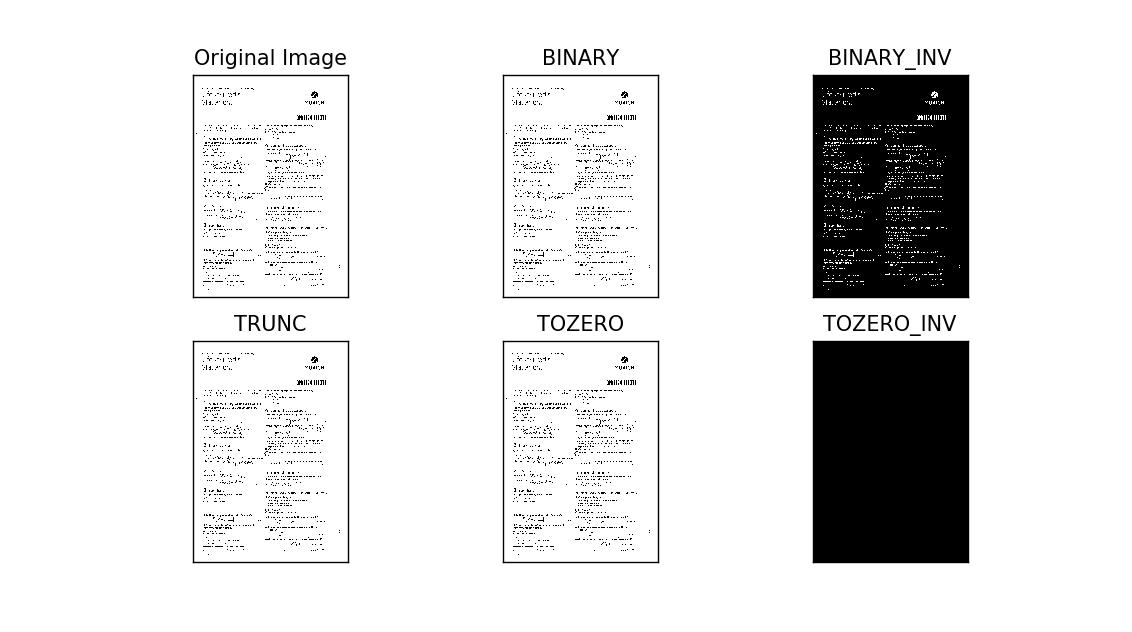

In [9]:
img = cv2.imread('03539292.tif',0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


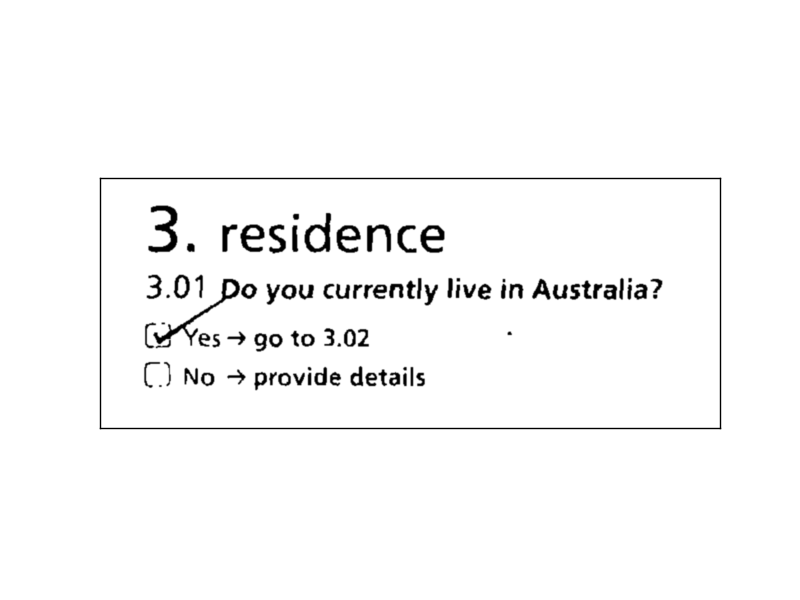

In [15]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


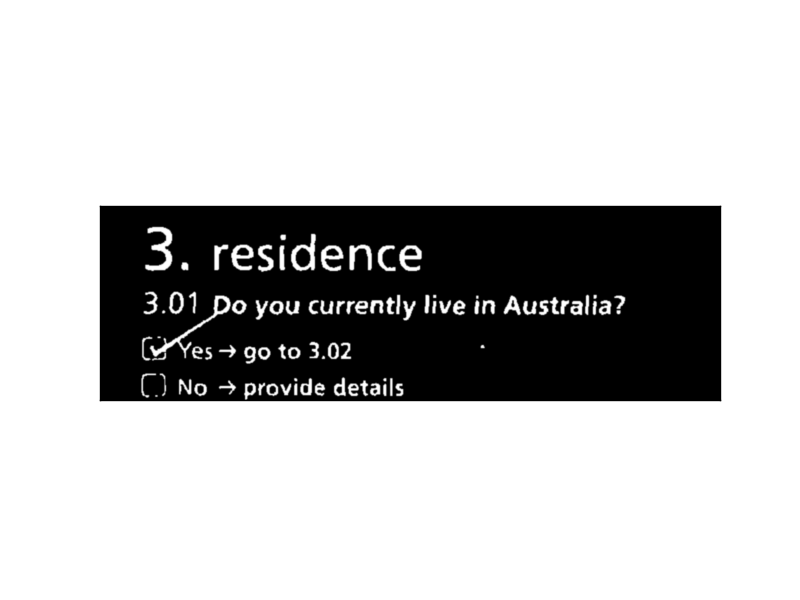

In [16]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


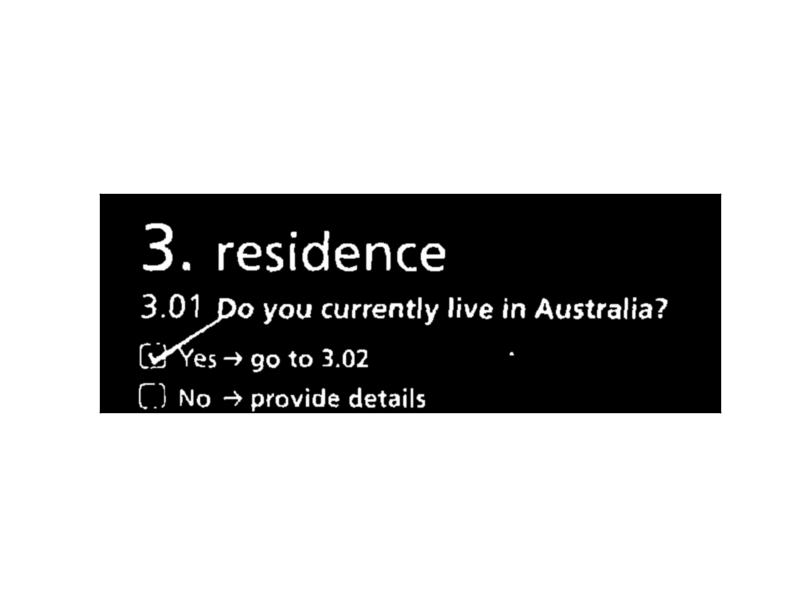

In [17]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


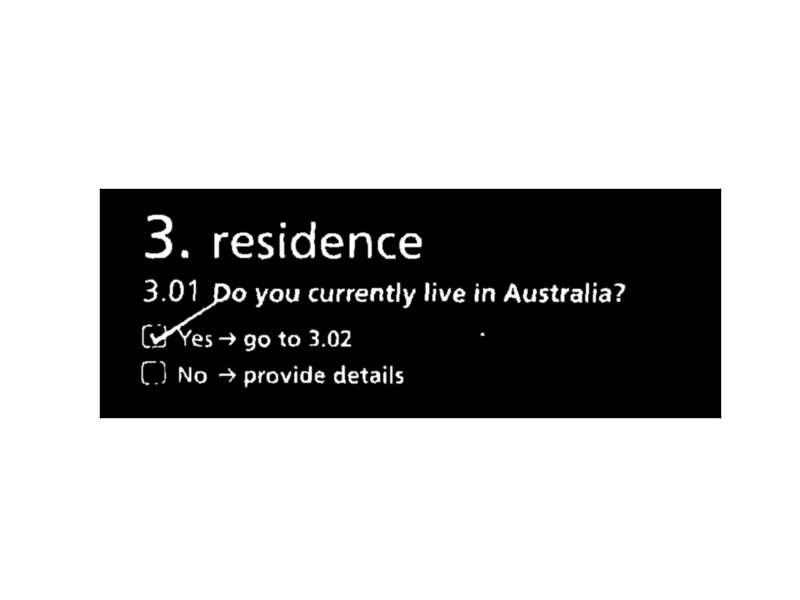

In [18]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


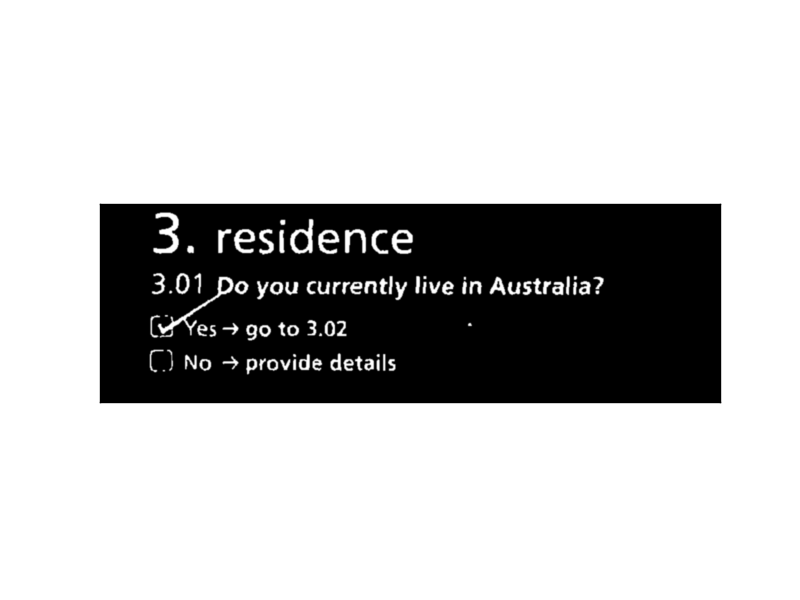

In [24]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(gray,120,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


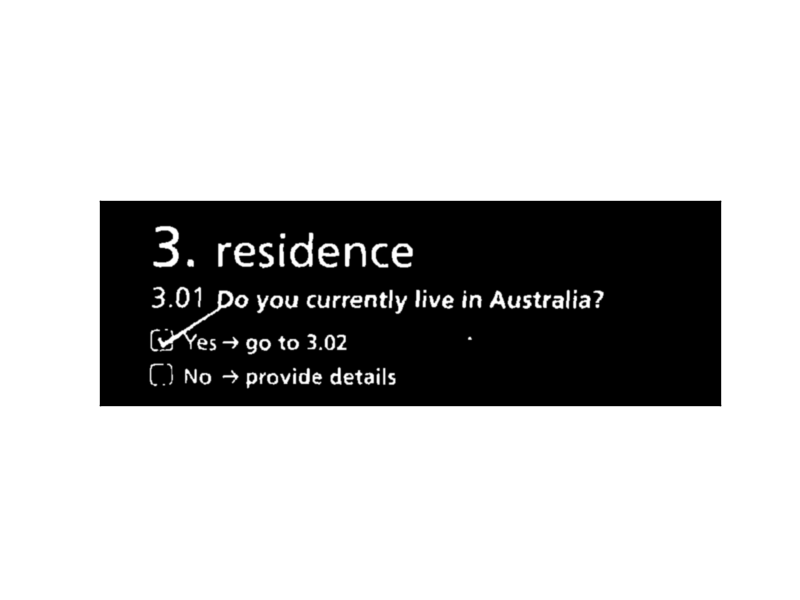

In [46]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


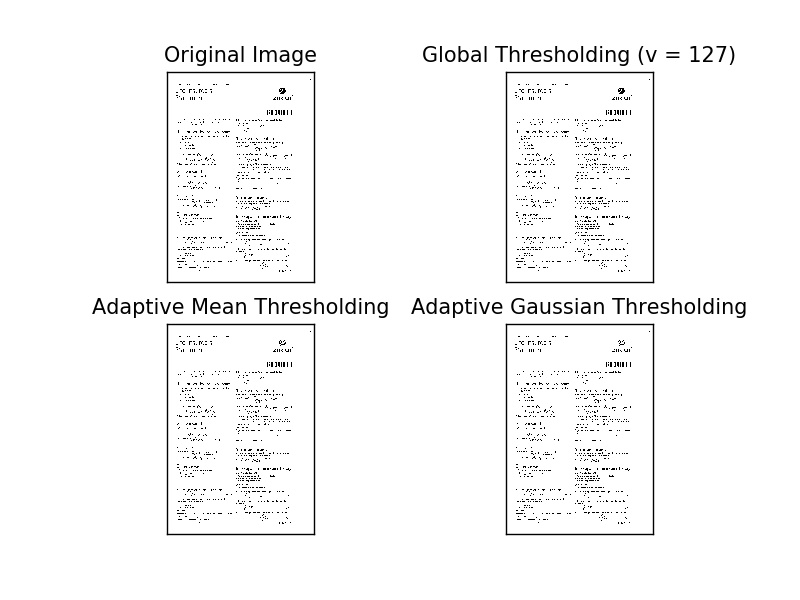

In [27]:
img = cv2.imread('03539292.tif',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

<IPython.core.display.Javascript object>


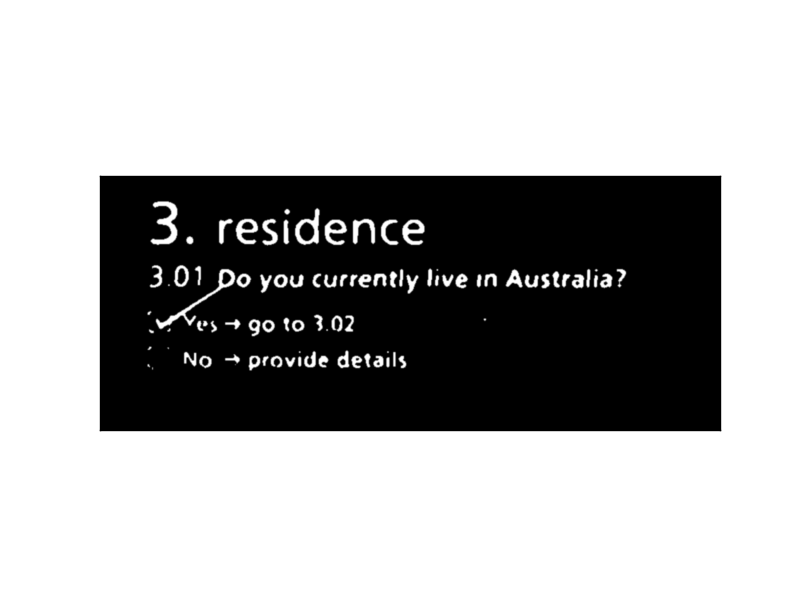

In [30]:
img = cv2.imread('03539292.tif',0)
img = cv2.medianBlur(img,5)

th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)

plt.imshow(th3, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


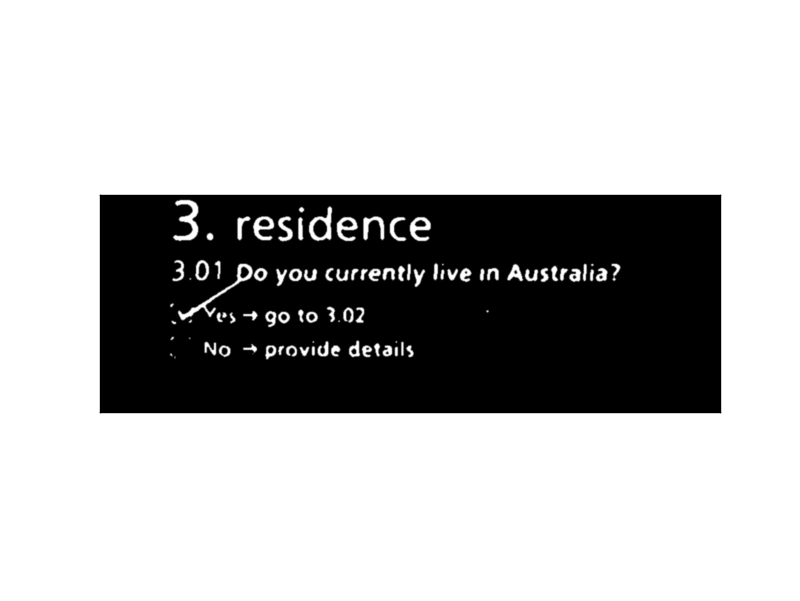

In [43]:
img = cv2.imread('03539292.tif',0)
img = cv2.medianBlur(img,5)

th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,5)

plt.imshow(th3, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


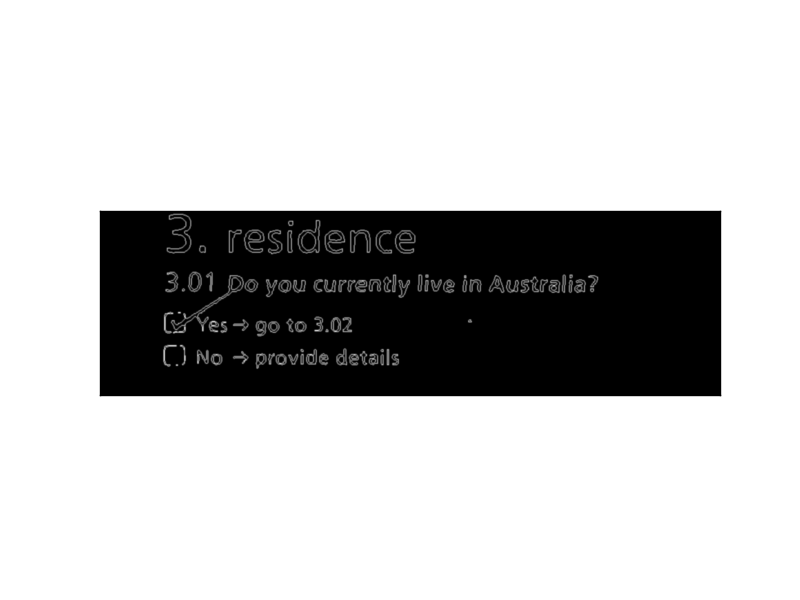

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [47]:
img = cv2.imread("03539292.tif")
laplacian = cv2.Laplacian(img,cv2.CV_64F)
plt.imshow(laplacian, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


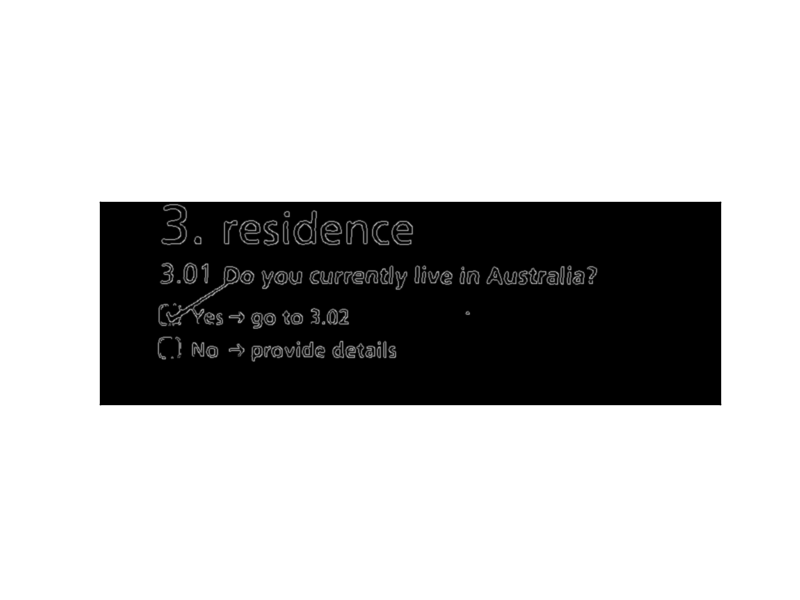

In [48]:
img = cv2.imread("03539292.tif")
edges = cv2.Canny(img,100,200)
plt.imshow(edges, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


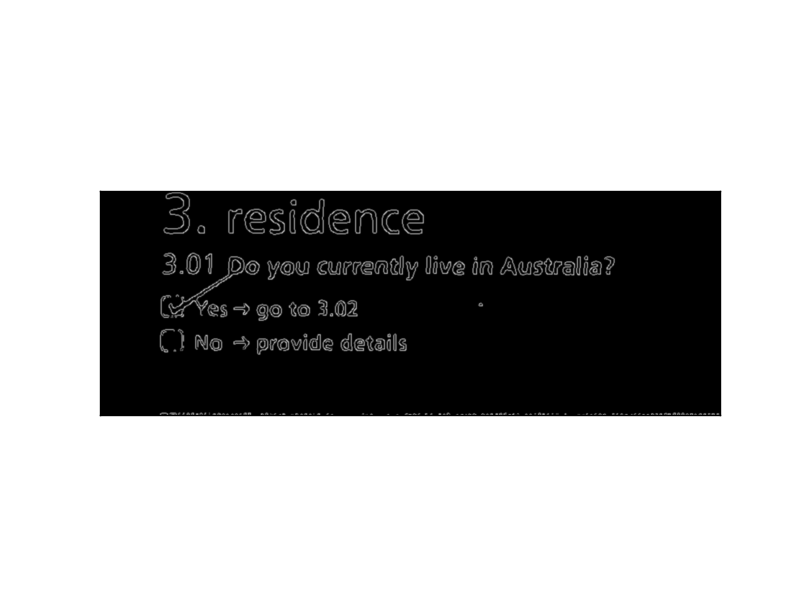

In [49]:
img = cv2.imread("03539292.tif")
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
plt.imshow(edges, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


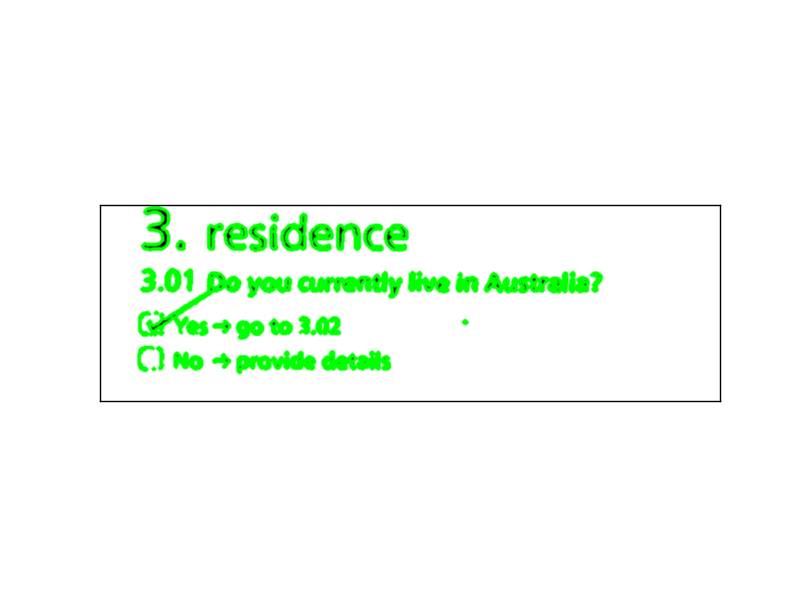

In [56]:
img = cv2.imread("03539292.tif")
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


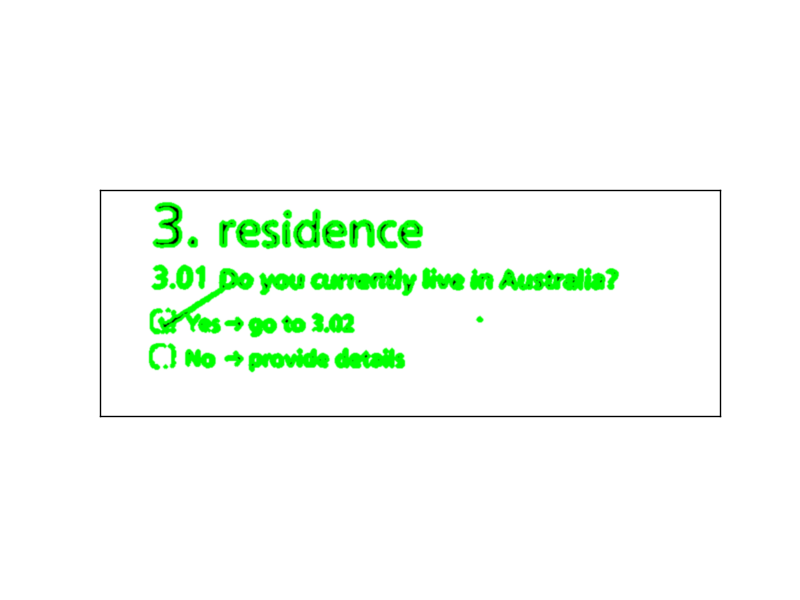

In [57]:
img = cv2.imread("03539292.tif")
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


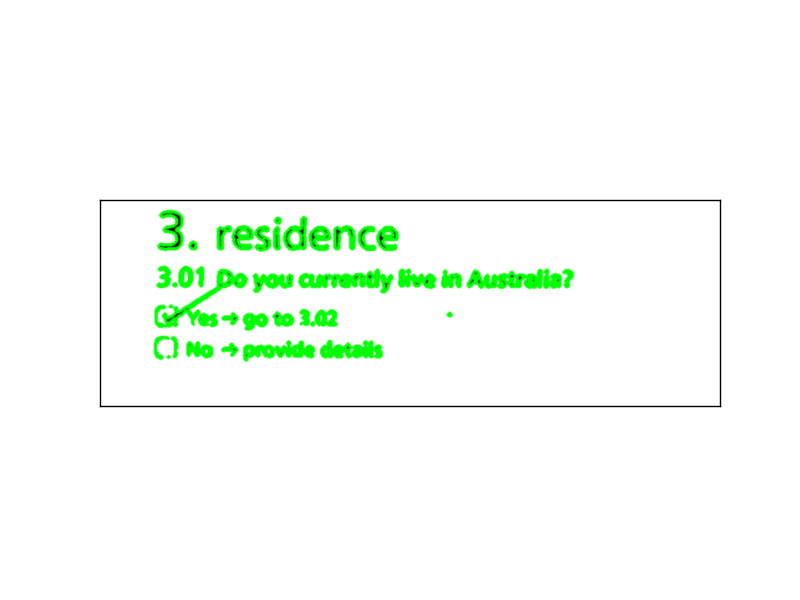

In [68]:
img = cv2.imread("03539292.tif")
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img, contours, -1, (0,255,0), 3,4)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


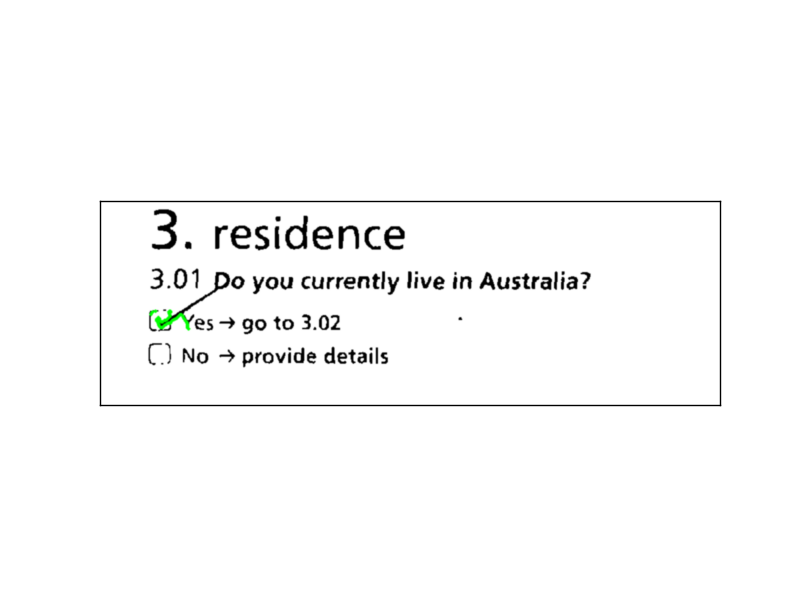

In [84]:
img = cv2.imread("03539292.tif")
ret,thresh2 = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[2650:2653]
img = cv2.drawContours(img, cnt, -1, (0,255,0), 3)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


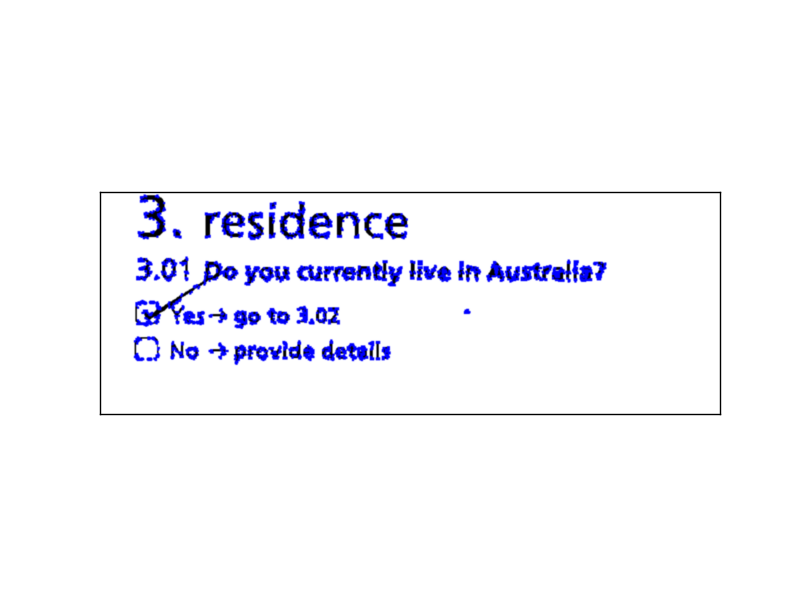

In [85]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


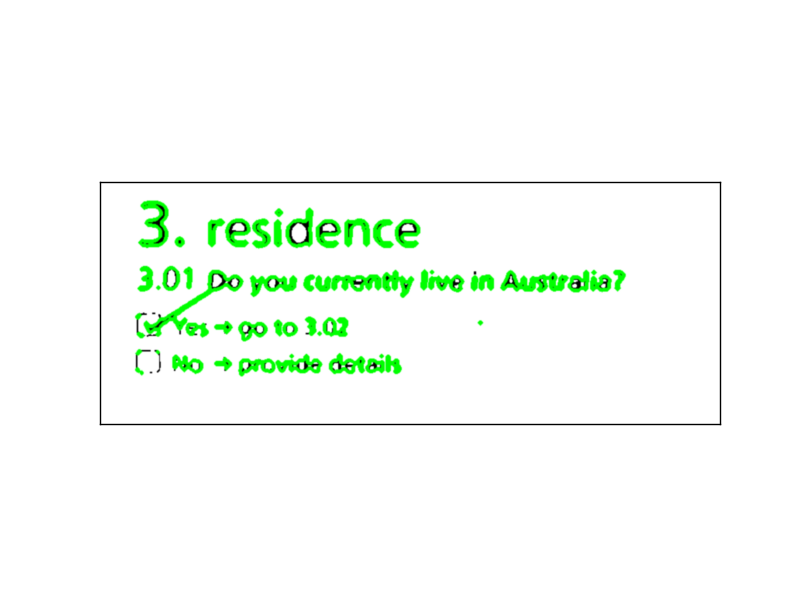

In [89]:
image = cv2.imread("03539292.tif")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(blur, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen,160,255, cv2.THRESH_BINARY_INV)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
img = cv2.drawContours(image, cnts, -1, (0,255,0), 3)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# new approach

<IPython.core.display.Javascript object>


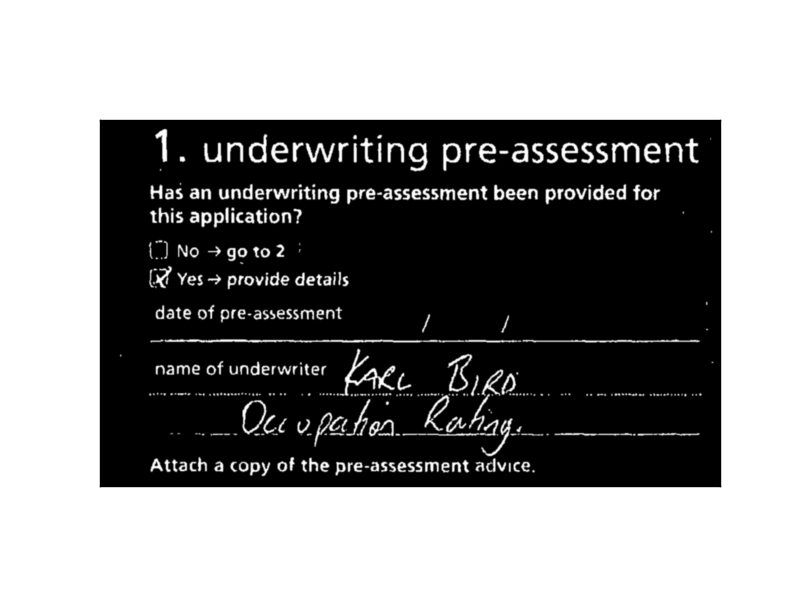

'Ue CC rR UC RC m Chi Re Lara BL\n\nLife Insured’s\nStatement\n\nPlease fill out a separate Lite Inisured’s Statement for each\ninsured life, The Life insured’s statement starts on this\npage and ends on page 27.\n\n1. underwriting pre-assessment\n\nHas an underwriting pre-assessment been provided for\n\nbales) ey si(e-harela ka\n\nOR eee kre\n\nMeek elie\n\ndate of pre-assessment yi y\n\nname of underwriter [Za\nmez v a) 102. ways Oa a\n\nOe\n\n  \n\nAttach a copy of the pre-assessment advice.\n\n2. life insured\n\nClMrs {.)Ms () Miss (7) Other:\n\nenya aeap\nCIM earns aware nl\n\naan tarts\ndate of birth\n\n \n\n \n\n   \n  \n\nLae\n\nRRO Cwm maa)\ncountry of Oh Bustyed awe\n\n3. residence\n\nROM Tome mae culAMie Eiri Pa\n\neae felomCemcmtys\n\nC) No > provide details\n\n3.02 How a you been en in Australia?\n\n \n\nyears}\n\nmonths\n\n3.03 Are you an Australian citizen, or do you hold\npermanent residency status?\n\neek eer)\n\nMEN Mes tone ory ts\n\nvisa type\n\nexpiry date\n\n \n\n

In [92]:
img = cv2.imread("03539292.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
# Adding custom options
custom_config = r'--oem 3 --psm 4'
pytesseract.image_to_string(thresh2, config=custom_config)

In [97]:
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(thresh2, config=custom_config)

";\ni oa\nj\nUe CC rR UC RC m Chi Re Lara BL |\nMom ASOlActens 7 ae :\nStatement | ZURICH\n|\nPlease fill out a separate Lite fisured’s Statement for each 3.04 Have you applied for permanent residency? , to\ninsured life, The Life insured’s statement starts on this ROE TTX Ce, “\npage and ends on page 27. ; | : 7\n: (3 No > Do you intend to apply?\n; D ea\n1. underwriting pre-assessment 0 No\nHas an underwriting pre-assessment been provided for , .\nea ~ 4. current occupation\nt) a Re 4.01 What is your current occupation and industry?\nMeek elie Prnrracteetet iT) ‘on zim WA ;\ndate of pre-assessment Fi i oo ecuututnmens vs unsenaonl C3 OTe Ameo eee\n—— 3 vam\n| name of underwriter ‘ZN i 5 current company/employer name Vi , =!\n| . . Tcleradag 5\nne 7a” ee ee a y ss © anne a\nAttach a copy of the pre-assessment advice. COP Near m Re eee r ee Teta\ni These include but are not limited to such hazardous duties.\n|: : - ; as working at heights of 10 metres or more, underground, ;\nW . | i a

In [98]:
custom_config = r'--oem 3 --psm 5'
pytesseract.image_to_string(thresh2, config=custom_config)

're\n| a ark ar a\n— poo: H > poi TUT ees Soper\n| Cae 2 eee Aa\n| — j iN ear Ps ee 2 ro) € 2! & yg on\nmay — a E Sea) Uo a ne $ 4 ; ce) 5| S ge! \'o\n. fad == « ee ene are eG} ES 74 3 eB} 8 El oe\na a 4 re rome a poo & oon a s if iy\n, a) — an 3: ih ms eo 5 ro 2 2 3 oul &\n—— o aN 3 Fs cs ro H i H Fi ¢ i 4 iat gs\nAN} — ae SECs er B So E re\n— 3 5] ae i £&t s P| | 3 iS E M i .2\n— fo: ; Po\n— ae cst 8 pr 5 oe 3 3 | @\n= s oe ee ee i See: I a 5\n; — ¢ a a ae as) Ae = po aan i) 3 a ad\n7 = iJ a q aay ee ees) ry : F iw i = - ~ FA a)\nE soa § P ae Rose oS poog ob es ° Fy a ag va\n| a ee ee ane ar g |\nes = ¥ , a foes rr a 5; ae pS oa,\nb : i H F = cj Pos 3S 2\n5 & oe ee a a | ae Cc a. rd ir ee\n3 2 SC ae ee ee eee aN ee =X\n3 2 a aoe oa no ae oO | S§\n. Hi H S i cs] 4\na OS arc Net eee ee a iio NY OS 2 8 a | §\n3 s : a ae ai . p\n| ae: ee ee ee ee oO a eee ne: ;\na a | Ss 22s ee ona om EGE a > i\n9582 2D <P) a re nae i Gs a a SEG a! ee Py\nPd pa TEA a a ee pois (<0 ed a (ok cn - ne c i; =

In [99]:
custom_config = r'--oem 3 --psm 11'
pytesseract.image_to_string(thresh2, config=custom_config)

'—\n\nSER Cm seem nisms leer mrAt RG\n\nLife Insured’s\n\nZ\n\nStatement\n\nZURICH\n\nA AAA\n\nPlease fill out a separate Lite Inisured’s Statement for each\n\n3.04 Have you applied for permanent residency?\n\ninsured life, The Life {nsured’s statement starts on this\n\nShee aCe\n\npage and ends on page\n\nra\n\n(3 No > Do you intend to apply?\n\nea\n\nOt\n\n1. underwriting pre-assessment\n\nHas an underwriting pre-assessment been provided for\n\nbales) ey si(e-harela ka\n\n4. current occupation\n\nOI ome -(- 0\n\n4.01 What is your current occupation and industry?\n\nMane provide details\n\ncurrent occupation\n\nNN\n\na\n\ndate of pre-assessment\n\nOne dae\n\nOYA\n\n/\n\ni\n\neve arene Tent ett Seen OSS SEL ICTS\n\nsetfeegettanienetenee\n\na\n\nieee elaaeaiaenl Tatar f\n\n\'\n\nname of underwriter ma\n\nome\n\nae\n\noon Vv fe 7" an\n\n—\n\nindustry er, nO\n\nEy\n\nAttach a copy of the pre-assessment advice\n\nNOP NCETM m ce me Mireles\n\nThese include but are not limited to such hazard

<IPython.core.display.Javascript object>


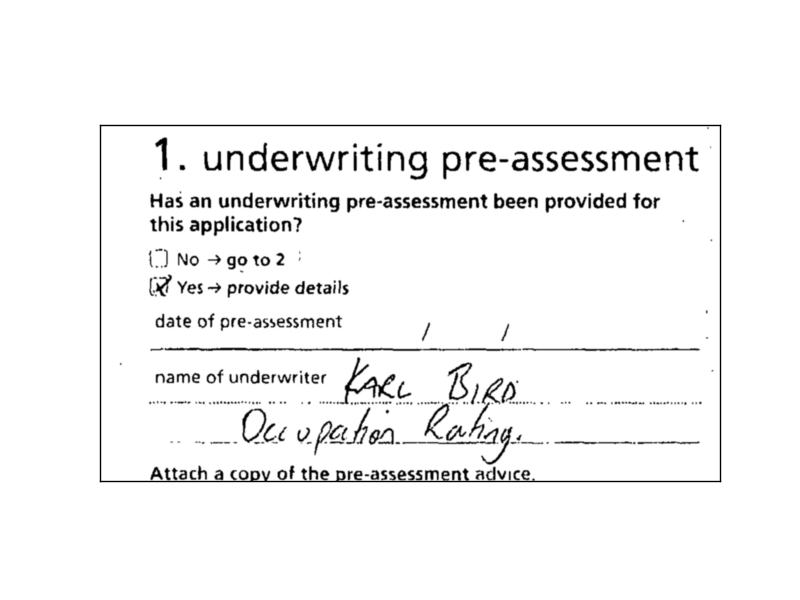

"i\n{ ae\n{\nThis form is dated 1 March 2013 and is valid until 28 February 2014 |\nLife Insured’s 7 ae :\nStatement | ZURICH\n|\nPlease fill out a separate Lite tisured’s Statement for each 3.04 Have you applied for permanent residency? . to\ninsured life, The Life insured’s statement starts on this C) Yes go to4 “\npage and ends on page 27. . { ‘ .\n° (3 No > Do you intend to apply?\n‘ : ©) Yes\n1. underwriting pre-assessment 0 No\nHas an underwriting pre-assessment been provided for . .\nthis application? — 4. current occupation\ntJ No > goto2 ° 4.01 What is your current occupation and industry?\nld Yes > provide details current occupation ‘on db / \\\ndate of pre-assessment / / oo cecruutntimens vs unsamaaml C3 ntall Thou bt renee |\n—— 3 a!\n| name of underwriter Le i . current company/employer name Mi ' =!\n| . . industry ‘\nee poten Kechag. a a ¥ sa © ane 2.\nAttach a copy of the pre-assessment advice. 4.02 Are any of your duties hazardous?\n‘ These include but are not limited t

In [101]:
img = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

# OCR

In [107]:
args = {"image":"03539292.tif", "east":"frozen_east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [108]:
image = cv2.imread(args['image'])

#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [109]:
# load the pre-trained EAST model for text detection 
net = cv2.dnn.readNet(args["east"])

# The following two layer need to pulled from EAST model for achieving this. 
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
    (numR, numC) = prob_score.shape[2:4]
    boxes = []
    confidence_val = []

    # loop over rows
    for y in range(0, numR):
        scoresData = prob_score[0, 0, y]
        x0 = geo[0, 0, y]
        x1 = geo[0, 1, y]
        x2 = geo[0, 2, y]
        x3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for i in range(0, numC):
            if scoresData[i] < args["min_confidence"]:
                continue

            (offX, offY) = (i * 4.0, y * 4.0)

            # extracting the rotation angle for the prediction and computing the sine and cosine
            angle = anglesData[i]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # using the geo volume to get the dimensions of the bounding box
            h = x0[i] + x2[i]
            w = x1[i] + x3[i]

            # compute start and end for the text pred bbox
            endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
            endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
            startX = int(endX - w)
            startY = int(endY - h)

            boxes.append((startX, startY, endX, endY))
            confidence_val.append(scoresData[i])

    # return bounding boxes and associated confidence_val
    return (boxes, confidence_val)

In [110]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    #extract the region of interest
    r = orig[startY:endY, startX:endX]

    #configuration setting to convert image to string.  
    configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(r, config=configuration)

    # append bbox coordinate and associated text to the list of results 
    results.append(((startX, startY, endX, endY), text))

este

nsured’s

Sys

URICH”

NAL

sete

re

alte.

ee

see

e-assessmen

life

eS

ee

cures

Hila

Stater

residenc

ar

life

sm



<IPython.core.display.Javascript object>


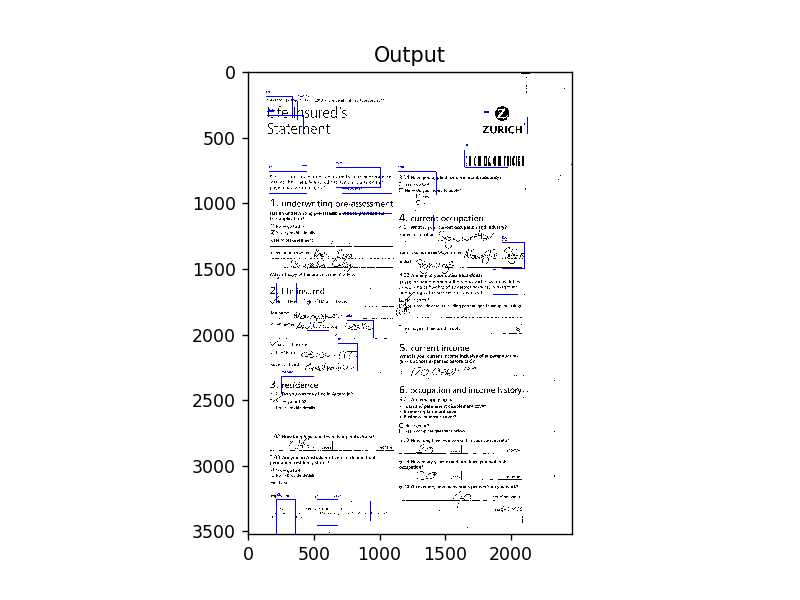

In [111]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
    # display the text detected by Tesseract
    print("{}\n".format(text))

    # Displaying text
    text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
    cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),(0, 0, 255), 2)
    cv2.putText(orig_image, text, (start_X, start_Y - 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

# ROI

(T] No > go to2 °
lg Yes > provide details


<IPython.core.display.Javascript object>


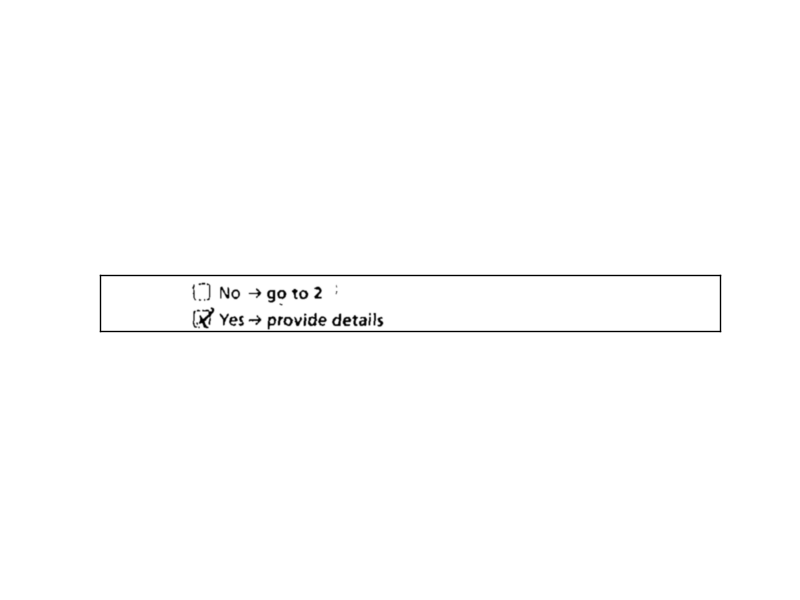

In [152]:
image = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = 0, int(dimensions[0]*.325), int(dimensions[1]*.9/2), 100
ROI = image[y:y+h,x:x+w]
data = pytesseract.image_to_string(ROI, lang='eng',config='--psm 6')
print(data)

plt.imshow(ROI, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [154]:
pytesseract.image_to_data(ROI, output_type=Output.DICT)

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
 'word_num': [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5],
 'left': [0,
  165,
  165,
  165,
  165,
  215,
  273,
  301,
  343,
  421,
  166,
  166,
  214,
  266,
  300,
  415],
 'top': [0, 14, 14, 14, 14, 21, 24, 27, 21, 18, 58, 58, 69, 72, 68, 68],
 'width': [1108,
  341,
  341,
  259,
  32,
  35,
  12,
  28,
  53,
  3,
  340,
  38,
  43,
  22,
  105,
  91],
 'height': [100, 83, 83, 40, 32, 22, 17, 27, 22, 16, 39, 37, 22, 17, 29, 24],
 'conf': ['-1',
  '-1',
  '-1',
  '-1',
  0,
  95,
  60,
  76,
  76,
  24,
  '-1',
  51,
  95,
  87,
  96,
  96],
 'text': ['',
  '',
  '',
  '',
  '(T]',
  'No',
  '>',
  'go',
  'to2',
  '°',
  '',
  'lg',
  'Yes',
  '>',
  'provide',
  'det

(2)
be


<IPython.core.display.Javascript object>


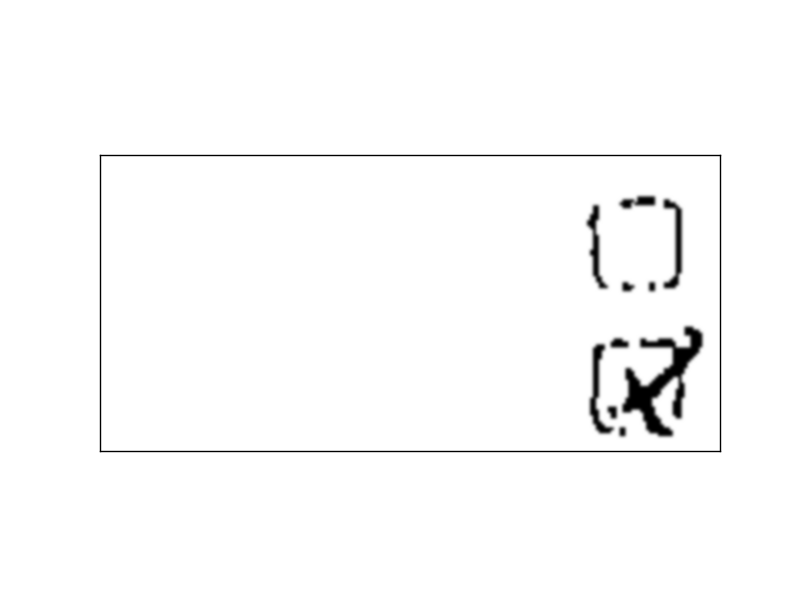

In [158]:
image = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = 0, int(dimensions[0]*.325), 210, 100
ROI = image[y:y+h,x:x+w]
data = pytesseract.image_to_string(ROI, lang='eng',config='--psm 6')
print(data)

plt.imshow(ROI, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [159]:
pytesseract.image_to_data(ROI, output_type=Output.DICT)

{'level': [1],
 'page_num': [1],
 'block_num': [0],
 'par_num': [0],
 'line_num': [0],
 'word_num': [0],
 'left': [0],
 'top': [0],
 'width': [210],
 'height': [100],
 'conf': ['-1'],
 'text': ['']}

13
528


<IPython.core.display.Javascript object>


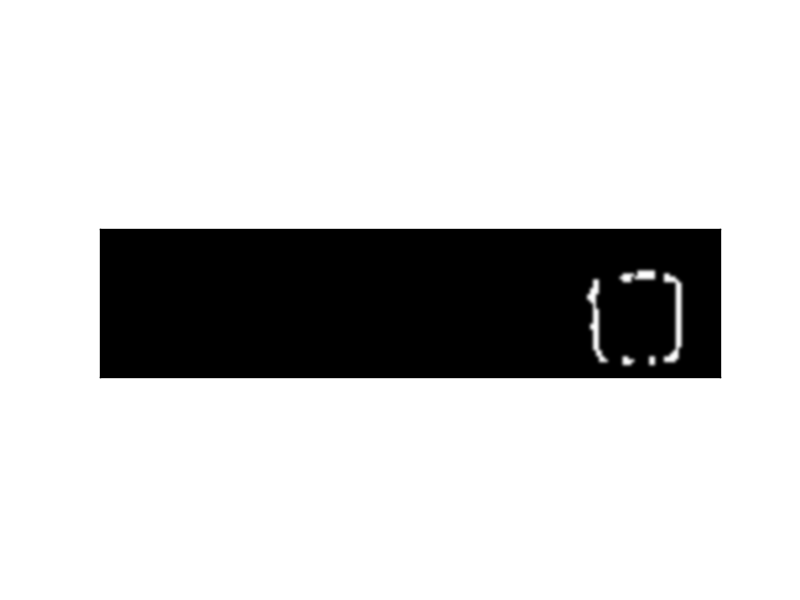

In [178]:
image = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = 0, int(dimensions[0]*.325), 210, 50
ROI = image[y:y+h,x:x+w]
ret,thresh2 = cv2.threshold(ROI,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
print(len(contours))
print(np.sum(thresh2 == 255))

plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

11
1350


<IPython.core.display.Javascript object>


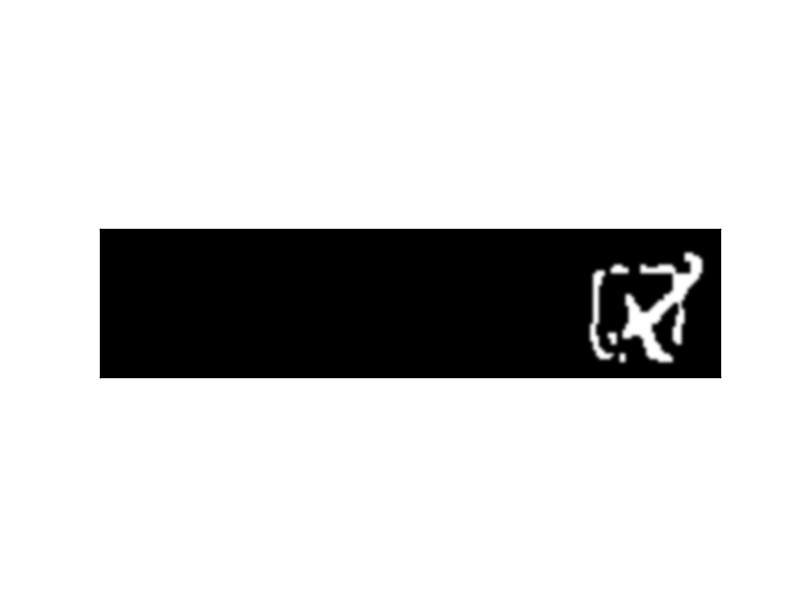

In [179]:
image = cv2.imread('03539292.tif', cv2.IMREAD_COLOR)
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = 0, int(dimensions[0]*.325)+50, 210, 50
ROI = image[y:y+h,x:x+w]
ret,thresh2 = cv2.threshold(ROI,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
print(len(contours))
print(np.sum(thresh2 == 255))

plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

13
951


<IPython.core.display.Javascript object>


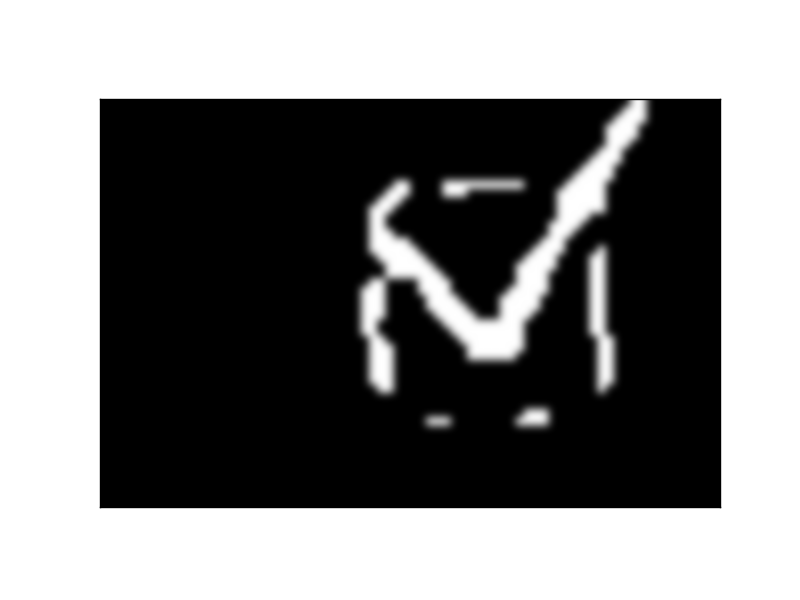

In [195]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[1]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = int(dimensions[1]*.58), int(dimensions[0]*.348), 76, 50
ROI = image[y:y+h,x:x+w]
ret,thresh2 = cv2.threshold(ROI,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
print(len(contours))
print(np.sum(thresh2 == 255))

plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

202
202
202
202
202
62
202


<IPython.core.display.Javascript object>


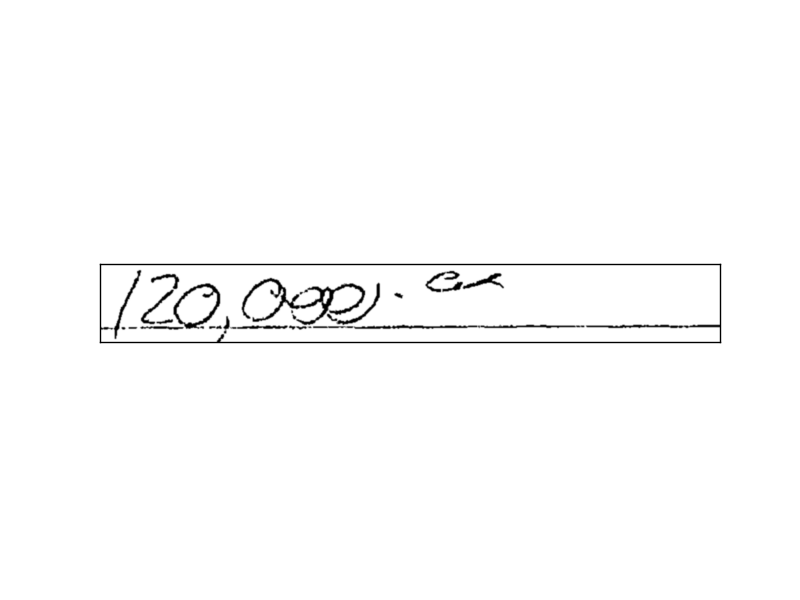

In [211]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 800, 100
ROI = image[y:y+h,x:x+w]
data = pytesseract.image_to_string(ROI, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)
data = pytesseract.image_to_string(ROI, lang='eng', config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)
data = pytesseract.image_to_string(ROI, lang='eng', config='--psm 6 --oem 1 -c tessedit_char_whitelist=0123456789')
print(data)
data = pytesseract.image_to_string(ROI, lang='eng', config='digits')
print(data)
ret,thresh2 = cv2.threshold(ROI,220,255,cv2.THRESH_BINARY_INV)
edges = cv2.Canny(thresh2,100,200)
data = pytesseract.image_to_string(thresh2, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)
data = pytesseract.image_to_string(edges, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)
ret,thresh2 = cv2.threshold(ROI,220,255,cv2.THRESH_BINARY)
data = pytesseract.image_to_string(thresh2, lang='eng', config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)

plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [212]:
pytesseract.image_to_data(thresh2, output_type=Output.DICT)

{'level': [1, 2, 3, 4, 5, 5, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 1, 1],
 'word_num': [0, 0, 0, 0, 1, 2, 3],
 'left': [0, 0, 0, 0, 0, 208, 432],
 'top': [0, 8, 8, 8, 8, 4, 9],
 'width': [800, 625, 625, 625, 167, 168, 58],
 'height': [100, 92, 92, 92, 92, 96, 73],
 'conf': ['-1', '-1', '-1', '-1', 31, 13, 26],
 'text': ['', '', '', '', '[ZO', 'OF2)', 'or']}

<IPython.core.display.Javascript object>


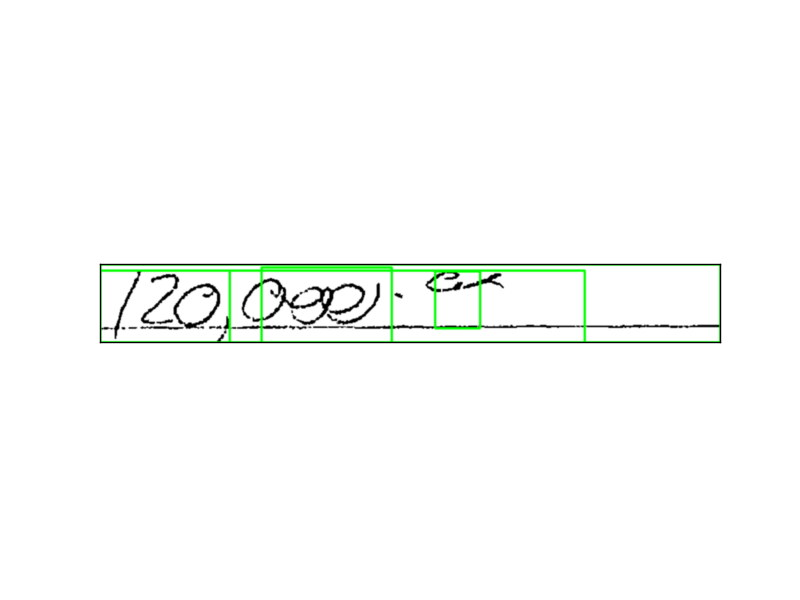

In [213]:
d = pytesseract.image_to_data(thresh2, output_type=Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(thresh2, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(thresh2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

22


<IPython.core.display.Javascript object>


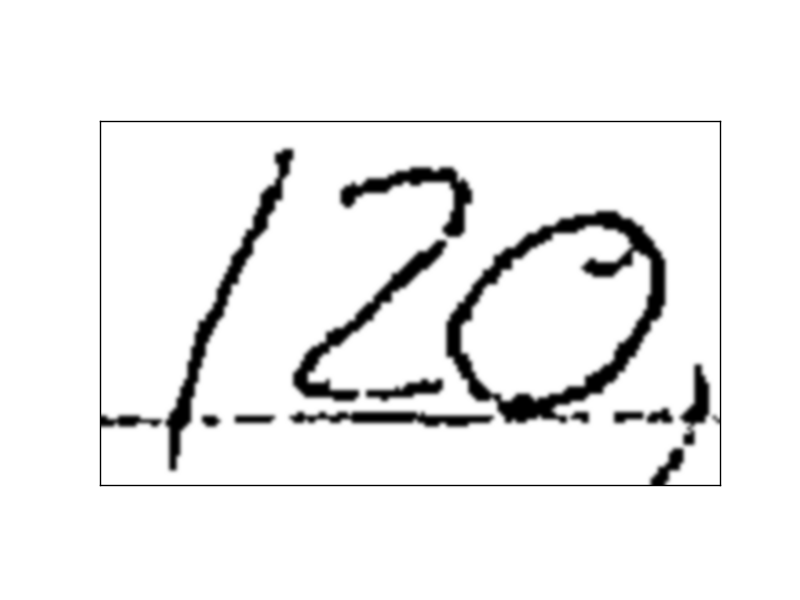

In [218]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 170, 100
ROI = image[y:y+h,x:x+w]
data = pytesseract.image_to_string(ROI, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
print(data)

plt.imshow(ROI, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# model

In [3]:
import numpy as np
from skimage.feature import hog
from sklearn import preprocessing
from collections import Counter
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [4]:
X, y = mnist['data'], mnist['target']
data = np.array(X, 'int16')
target = np.array(y, 'int')

In [5]:
list_hog = []
for feature in data:
    fd = hog(feature.reshape((28,28)), orientations=9, pixels_per_cell=(14,14),cells_per_block=(1,1))
    list_hog.append(fd)
hog_features = np.array(list_hog, 'float64')

In [6]:
preProcess = preprocessing.MaxAbsScaler().fit(hog_features)
hog_features_transformed = preProcess.transform(hog_features)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(hog_features_transformed,target , random_state = 0)
Model = Model = MLPClassifier(activation='relu', hidden_layer_sizes=(200, 200), alpha = 0.3)
Model.fit(X_train, y_train)
print('Training Score :: {}\n'.format(Model.score(X_train, y_train)))
print('Testing Score :: {}\n'.format(Model.score(X_test, y_test)))

Training Score :: 0.8979809523809524

Testing Score :: 0.8923428571428571



In [8]:
from sklearn.externals import joblib
joblib.dump((Model, preProcess), 'ModelDigit42.pkl', compress=3)

C:\Users\jonathan.calmus\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['ModelDigit42.pkl']

In [9]:
from sklearn.externals import joblib
Model, preProcess = joblib.load('ModelDigit42.pkl')

[(22, 84, 1, 1), (101, 74, 1, 1), (66, 74, 2, 1), (163, 72, 2, 3), (133, 62, 12, 9), (62, 60, 4, 3), (28, 59, 2, 1), (98, 53, 2, 5), (32, 43, 5, 10), (136, 40, 4, 1), (98, 28, 2, 2), (92, 16, 1, 1)]
['1', '1', '1', '7', '2', '2', '1', '0', '8', '1', '1', '1']


<IPython.core.display.Javascript object>


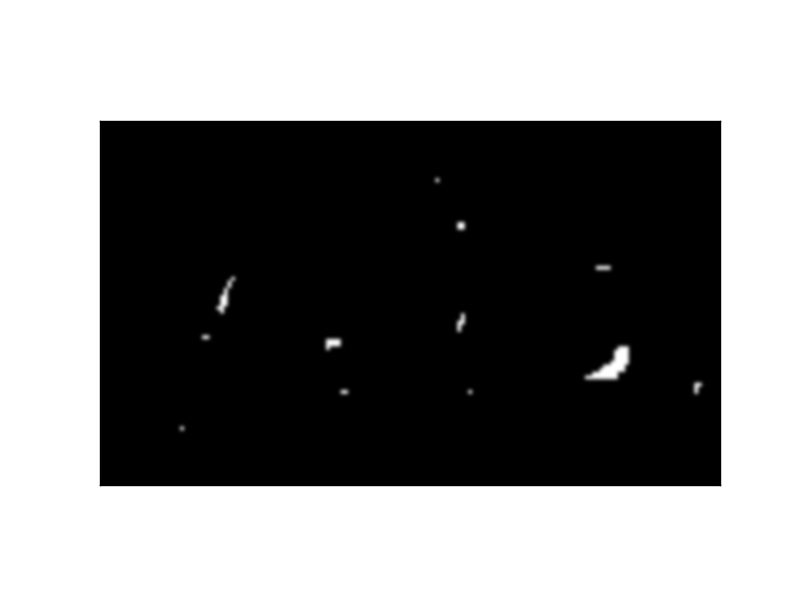

In [247]:
#Select directory of image file
img = ROI
# Convert to grayscale and apply Gaussian filtering
im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#im_gray = cv2.GaussianBlur(im_grey, (5, 5), 0)
ret, im_th = cv2.threshold(im_grey, 90, 255, cv2.THRESH_BINARY_INV)
# Find contours in the image
ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
print(rects)
digits = []
for rect in rects:
    # Draw the rectangles
    cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] / 2 - leng / 2)
    pt2 = int(rect[0] + rect[2] / 2 - leng / 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    if roi.any():
        roi = cv2.resize(roi, (28,28))
        roi = cv2.dilate(roi, (3, 3))
    if roi.size>0:
        roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1,1))
        roi_hog_fd = preProcess.transform(np.array([roi_hog_fd],    'float64'))
        nbr = Model.predict(roi_hog_fd)
        digits.append(str(int(nbr[0])))
        cv2.putText(img, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
print(digits)
plt.imshow(im_th, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<IPython.core.display.Javascript object>


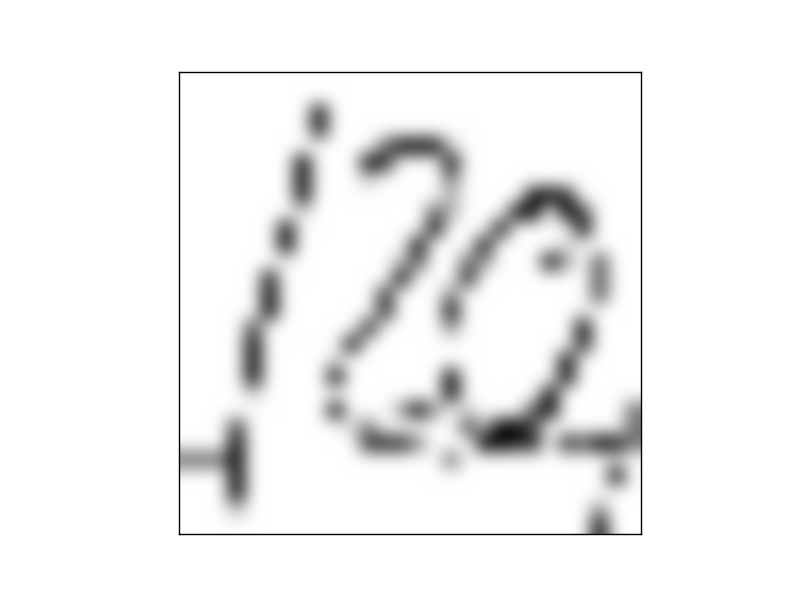

In [256]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]

x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 170, 100
ROI = image[y:y+h,x:x+w]
ROI = cv2.resize(ROI, (28,28))
#ROI = cv2.dilate(ROI, (3, 3))

digits = []
roi_hog_fd = hog(ROI, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1,1))
roi_hog_fd = preProcess.transform(np.array([roi_hog_fd], 'float64'))
nbr = Model.predict(roi_hog_fd)
digits.append(str(int(nbr[0])))
cv2.putText(ROI, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
plt.imshow(ROI, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

(3520, 2464, 3)
(100, 170, 3)


<IPython.core.display.Javascript object>


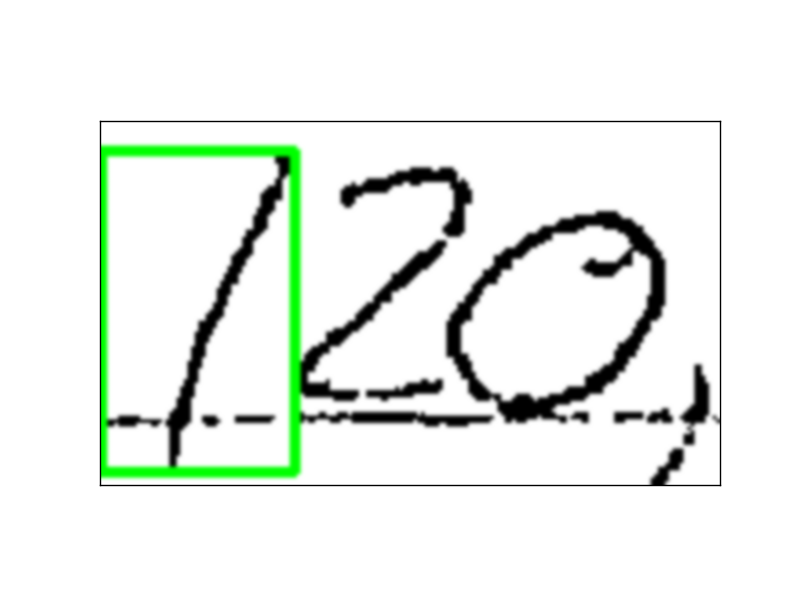

In [279]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]
print(dimensions)

x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 170, 100
ROI = image[y:y+h,x:x+w]
dimensions = ROI.shape
print(dimensions)
boxes = pytesseract.image_to_boxes(ROI) 
digits = []
for b in boxes.splitlines():
    b = b.split(' ')
    cv2.rectangle(ROI, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
plt.imshow(ROI, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

(3520, 2464, 3)
['1', '2', '6']


<IPython.core.display.Javascript object>


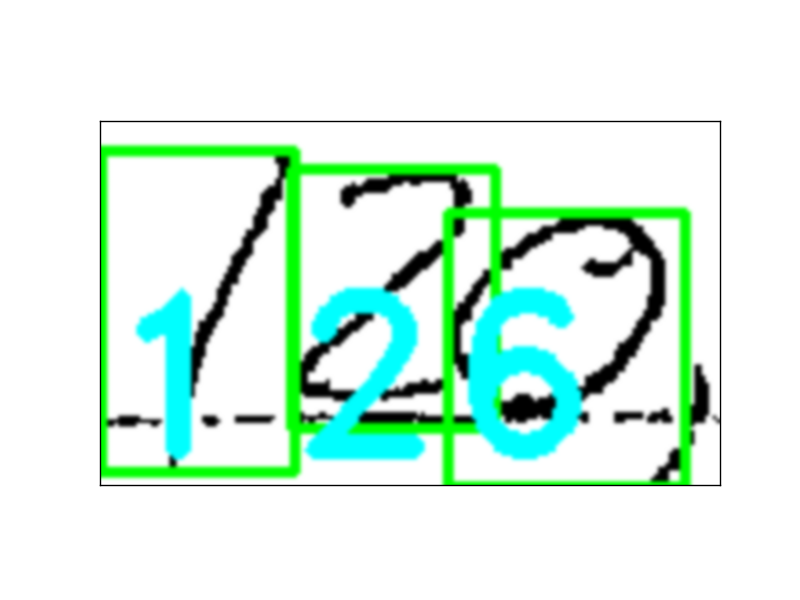

In [14]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]
print(dimensions)

x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 170, 100
#x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 800, 100
ROI2 = image[y:y+h,x:x+w]
boxes = pytesseract.image_to_boxes(ROI2) 
digits = []
for b in boxes.splitlines():
    b = b.split(' ')
    if int(b[3])-int(b[1])>30:
        cv2.rectangle(ROI2, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
        x = int(b[1])
        w = int(b[3])-int(b[1])
        y = h - int(b[4])
        h2 = int(b[4])
        roi = ROI2[y:y+h2,x:x+w]
        if roi.any():
            roi = cv2.resize(roi, (28,28))
            roi = cv2.dilate(roi, (3, 3))
        if roi.size>0:
            roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1,1))
            roi_hog_fd = preProcess.transform(np.array([roi_hog_fd], 'float64'))
            nbr = Model.predict(roi_hog_fd)
            digits.append(str(int(nbr[0])))
            cv2.putText(ROI2, str(int(nbr[0])), (x, h-10),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
print(digits)
plt.imshow(ROI2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

(3520, 2464, 3)
['1', '2', '0']


<IPython.core.display.Javascript object>


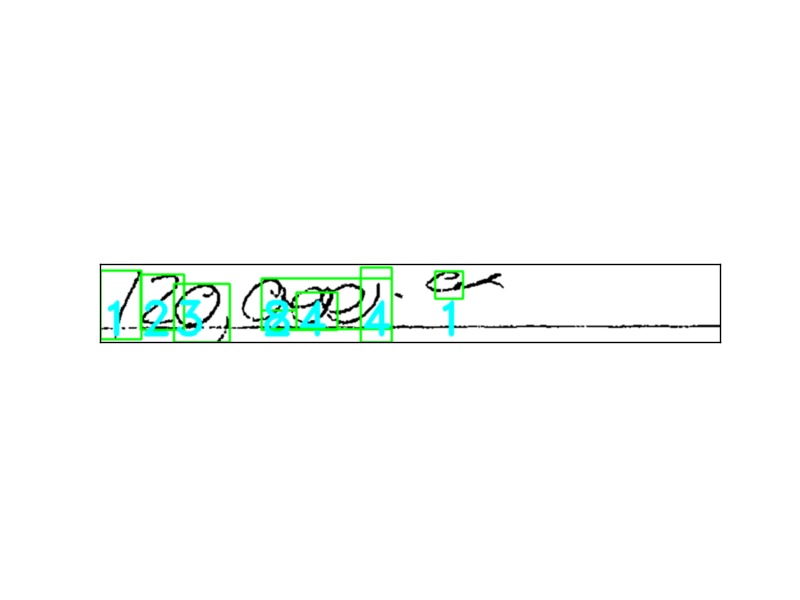

In [290]:
retval, img = cv2.imreadmulti('03539292.tif', flags =cv2.IMREAD_COLOR)
image=img[0]
#thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
dimensions = image.shape
dimensions[0]
print(dimensions)

#x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 170, 100
x,y,w,h = int(dimensions[1]*.495), int(dimensions[0]*.635), 800, 100
ROI2 = image[y:y+h,x:x+w]
boxes = pytesseract.image_to_boxes(ROI2) 
digits = []
for b in boxes.splitlines():
    b = b.split(' ')
    if int(b[3])-int(b[1])>30:
        cv2.rectangle(ROI2, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
        x = int(b[1])
        w = int(b[3])-int(b[1])
        y = h - int(b[4])
        h2 = int(b[4])
        roi = ROI2[y:y+h2,x:x+w]
        if roi.any():
            roi = cv2.resize(roi, (28,28))
            roi = cv2.dilate(roi, (3, 3))
        if roi.size>0:
            roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1,1))
            roi_hog_fd = preProcess.transform(np.array([roi_hog_fd], 'float64'))
            nbr = Model.predict(roi_hog_fd)
            digits.append(str(int(nbr[0])))
            cv2.putText(ROI2, str(int(nbr[0])), (x, h-10),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
print(digits)
plt.imshow(ROI2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [5]:
from nltk import ngrams
sentence="to be or not to be"

n=3
trigrams=ngrams(sentence.split(),n)
for grams in trigrams:
    print(grams)

('to', 'be', 'or')
('be', 'or', 'not')
('or', 'not', 'to')
('not', 'to', 'be')


# Azure API

In [45]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
#from azure.cognitiveservices.vision.computervision.models import TextOperationStatusCodes
#from azure.cognitiveservices.vision.computervision.models import TextRecognitionMode
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

In [4]:
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

NameError: name 'endpoint' is not defined

In [7]:
# Add your Computer Vision subscription key to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = "322eb568-033b-4e2f-bd26-f7437988a574"
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()
# Add your Computer Vision endpoint to your environment variables.
if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
else:
    print("\nSet the COMPUTER_VISION_ENDPOINT environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()


Set the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.
**Restart your shell or IDE for changes to take effect.**


SystemExit: 

In [14]:
subscription_key = "e08196667caa44d19078238763ee002f"
endpoint = "https://zuzu.cognitiveservices.azure.com/"

In [11]:
import json
import os
import sys
import requests
import time
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image
from io import BytesIO

{
    "status": "running",
    "createdDateTime": "2020-06-25T12:49:53Z",
    "lastUpdatedDateTime": "2020-06-25T12:49:53Z"
}
{
    "status": "running",
    "createdDateTime": "2020-06-25T12:49:53Z",
    "lastUpdatedDateTime": "2020-06-25T12:49:53Z"
}
{
    "status": "succeeded",
    "createdDateTime": "2020-06-25T12:49:53Z",
    "lastUpdatedDateTime": "2020-06-25T12:49:55Z",
    "analyzeResult": {
        "version": "3.0.0",
        "readResults": [
            {
                "page": 1,
                "angle": 0.6856,
                "width": 2661,
                "height": 1901,
                "unit": "pixel",
                "lines": [
                    {
                        "boundingBox": [
                            38,
                            650,
                            2572,
                            699,
                            2570,
                            854,
                            37,
                            815
                      

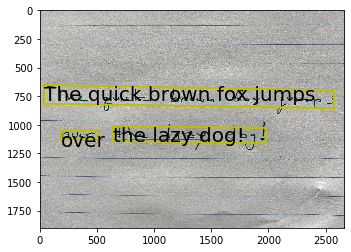

In [17]:
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to recognize.
image_url = "https://raw.githubusercontent.com/MicrosoftDocs/azure-docs/master/articles/cognitive-services/Computer-vision/Images/readsample.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
data = {'url': image_url}
response = requests.post(
    text_recognition_url, headers=headers, json=data)
response.raise_for_status()

# Extracting text requires two API calls: One call to submit the
# image for processing, the other to retrieve the text found in the image.

# Holds the URI used to retrieve the recognized text.
operation_url = response.headers["Operation-Location"]

# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    
    print(json.dumps(analysis, indent=4))

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
image = Image.open(BytesIO(requests.get(image_url).content))
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
plt.show()

In [36]:
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

image_path = "new.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(text_recognition_url, headers=headers, params=params, data = image_data)

response.raise_for_status()

# Extracting text requires two API calls: One call to submit the
# image for processing, the other to retrieve the text found in the image.

# Holds the URI used to retrieve the recognized text.
operation_url = response.headers["Operation-Location"]

# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    
    print(json.dumps(analysis, indent=4))

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
image = Image.open(BytesIO(requests.get(image_url).content))
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
plt.show()

AttributeError: 'NoneType' object has no attribute 'dumps'

In [41]:
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to recognize.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/new.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {'visualFeatures': 'Categories,Description,Color'}
response = requests.post(
    text_recognition_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(analysis)
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [68]:
region = "southeastasia" #For example, "westus"
api_key = "e08196667caa44d19078238763ee002f"
path_to_file = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/income.png"

# Read file
with open(path_to_file, 'rb') as f:
    data = f.read()

# Set request headers
headers = dict()
headers['Ocp-Apim-Subscription-Key'] = api_key
headers['Content-Type'] = 'application/octet-stream'

# Set request querystring parameters
params = {'visualFeatures': 'Color,Categories,Tags,Description,ImageType,Faces,Adult'}
params = {'language': 'en', 'detectOrientation': 'true'}

# Make request and process response
response = requests.request('post', "https://{}.api.cognitive.microsoft.com/vision/v3.0/analyze".format(region), data=data, headers=headers, params=params)

if response.status_code == 200 or response.status_code == 201:

    if 'content-length' in response.headers and int(response.headers['content-length']) == 0:
        result = None
    elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str):
        if 'application/json' in response.headers['content-type'].lower():
            result = response.json() if response.content else None
        elif 'image' in response.headers['content-type'].lower():
            result = response.content

        print(result)
else:

    print("Error code: %d" % response.status_code)
    print("Message: %s" % response.json())

Error code: 202


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [65]:
response.json()

{'categories': [{'name': 'text_', 'score': 0.2734375},
  {'name': 'text_menu', 'score': 0.68359375}],
 'requestId': '738131ff-13be-4045-9566-b23227d5e4ee',
 'metadata': {'width': 1350, 'height': 2804, 'format': 'Png'}}

In [66]:
analysis = response.json()
print(analysis)
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

{'categories': [{'name': 'text_', 'score': 0.2734375}, {'name': 'text_menu', 'score': 0.68359375}], 'requestId': '738131ff-13be-4045-9566-b23227d5e4ee', 'metadata': {'width': 1350, 'height': 2804, 'format': 'Png'}}


KeyError: 'description'

In [73]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO

ocr_url = endpoint + "vision/v3.0/ocr"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/income.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(ocr_url, headers=headers, params=params, data = image_data)
response.raise_for_status()

analysis = response.json()

# Extract the word bounding boxes and text.
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
word_infos

[{'boundingBox': '22,17,24,25', 'text': '5.'},
 {'boundingBox': '58,23,89,19', 'text': 'current'},
 {'boundingBox': '156,21,89,20', 'text': 'income'},
 {'boundingBox': '20,52,37,11', 'text': 'What'},
 {'boundingBox': '61,51,10,12', 'text': 'is'},
 {'boundingBox': '75,54,31,11', 'text': 'your'},
 {'boundingBox': '110,52,48,11', 'text': 'current'},
 {'boundingBox': '163,51,47,12', 'text': 'income'},
 {'boundingBox': '215,51,58,12', 'text': 'inclusive'},
 {'boundingBox': '277,50,14,12', 'text': 'Of'},
 {'boundingBox': '295,50,106,15', 'text': 'superannuation'},
 {'boundingBox': '20,68,29,14', 'text': '(less'},
 {'boundingBox': '54,68,56,12', 'text': 'business'},
 {'boundingBox': '114,71,62,11', 'text': 'expenses'},
 {'boundingBox': '181,67,44,12', 'text': 'before'},
 {'boundingBox': '229,67,33,14', 'text': 'tax)?'}]

In [76]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO

ocr_url = endpoint + "vision/v3.0/ocr"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/income2.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(ocr_url, headers=headers, params=params, data = image_data)
response.raise_for_status()

analysis = response.json()

# Extract the word bounding boxes and text.
line_infos = [region["lines"] for region in analysis["regions"]]
word_infos = []
for line in line_infos:
    for word_metadata in line:
        for word_info in word_metadata["words"]:
            word_infos.append(word_info)
word_infos

[]

## good code

In [97]:
api_key = "e08196667caa44d19078238763ee002f"
region = "southeastasia" #For example, "westus"
endpoint="https://{}.api.cognitive.microsoft.com/".format(region)
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/income.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(text_recognition_url, headers=headers, data = image_data)
response.raise_for_status()

operation_url = response.headers["Operation-Location"]

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()
    
    print(json.dumps(analysis, indent=4))

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False


{
    "status": "running",
    "createdDateTime": "2020-06-26T01:29:40Z",
    "lastUpdatedDateTime": "2020-06-26T01:29:40Z"
}
{
    "status": "succeeded",
    "createdDateTime": "2020-06-26T01:29:40Z",
    "lastUpdatedDateTime": "2020-06-26T01:29:41Z",
    "analyzeResult": {
        "version": "3.0.0",
        "readResults": [
            {
                "page": 1,
                "angle": -0.1496,
                "width": 459,
                "height": 131,
                "unit": "pixel",
                "lines": [
                    {
                        "boundingBox": [
                            418,
                            19,
                            419,
                            1,
                            424,
                            2,
                            423,
                            19
                        ],
                        "text": "--",
                        "words": [
                            {
                         

<IPython.core.display.Javascript object>


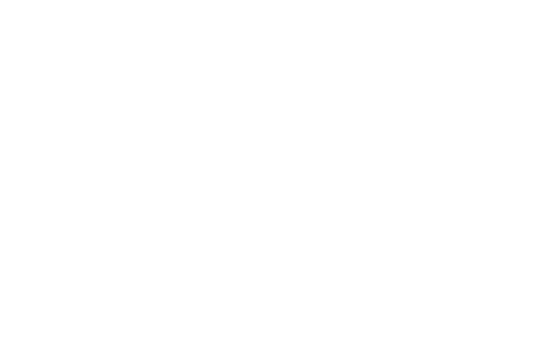

<IPython.core.display.Javascript object>


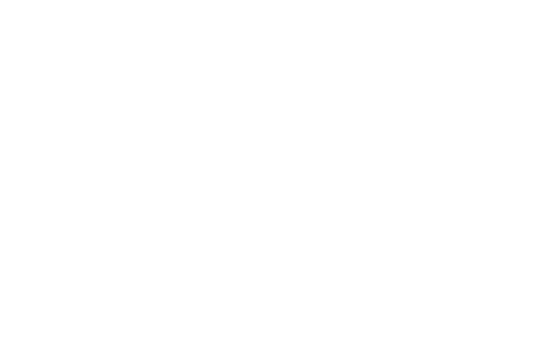

In [98]:
polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

# Display the image and overlay it with the extracted text.
image = Image.open(BytesIO(image_data))
ax = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1])
                for i in range(0, len(polygon[0]), 2)]
    text = polygon[1]
    patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
plt.show()

In [99]:
analysis

{'status': 'succeeded',
 'createdDateTime': '2020-06-26T01:29:40Z',
 'lastUpdatedDateTime': '2020-06-26T01:29:41Z',
 'analyzeResult': {'version': '3.0.0',
  'readResults': [{'page': 1,
    'angle': -0.1496,
    'width': 459,
    'height': 131,
    'unit': 'pixel',
    'lines': [{'boundingBox': [418, 19, 419, 1, 424, 2, 423, 19],
      'text': '--',
      'words': [{'boundingBox': [418, 19, 419, 3, 424, 3, 424, 18],
        'text': '--',
        'confidence': 0.86}]},
     {'boundingBox': [20, 16, 246, 17, 246, 44, 19, 43],
      'text': '5. current income',
      'words': [{'boundingBox': [21, 17, 47, 17, 47, 44, 20, 44],
        'text': '5.',
        'confidence': 0.985},
       {'boundingBox': [52, 17, 145, 19, 144, 43, 52, 44],
        'text': 'current',
        'confidence': 0.981},
       {'boundingBox': [150, 19, 246, 20, 246, 43, 150, 43],
        'text': 'income',
        'confidence': 0.985}]},
     {'boundingBox': [18, 50, 401, 49, 401, 64, 18, 65],
      'text': 'What is you

In [103]:
analysis["analyzeResult"]["readResults"][0]["lines"]

[{'boundingBox': [418, 19, 419, 1, 424, 2, 423, 19],
  'text': '--',
  'words': [{'boundingBox': [418, 19, 419, 3, 424, 3, 424, 18],
    'text': '--',
    'confidence': 0.86}]},
 {'boundingBox': [20, 16, 246, 17, 246, 44, 19, 43],
  'text': '5. current income',
  'words': [{'boundingBox': [21, 17, 47, 17, 47, 44, 20, 44],
    'text': '5.',
    'confidence': 0.985},
   {'boundingBox': [52, 17, 145, 19, 144, 43, 52, 44],
    'text': 'current',
    'confidence': 0.981},
   {'boundingBox': [150, 19, 246, 20, 246, 43, 150, 43],
    'text': 'income',
    'confidence': 0.985}]},
 {'boundingBox': [18, 50, 401, 49, 401, 64, 18, 65],
  'text': 'What is your current income inclusive of superannuation',
  'words': [{'boundingBox': [19, 51, 55, 51, 55, 65, 19, 66],
    'text': 'What',
    'confidence': 0.987},
   {'boundingBox': [57, 51, 69, 50, 69, 65, 58, 65],
    'text': 'is',
    'confidence': 0.988},
   {'boundingBox': [72, 50, 104, 50, 104, 65, 72, 65],
    'text': 'your',
    'confidence': 0

In [105]:
api_key = "e08196667caa44d19078238763ee002f"
region = "southeastasia" #For example, "westus"
endpoint="https://{}.api.cognitive.microsoft.com/".format(region)
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/income.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(text_recognition_url, headers=headers, data = image_data)
response.raise_for_status()

operation_url = response.headers["Operation-Location"]

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [line["text"]
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
    
polygons

['--',
 '5. current income',
 'What is your current income inclusive of superannuation',
 '(less business expenses before tax)?',
 '$ 20.000 . Grx']

In [106]:
api_key = "e08196667caa44d19078238763ee002f"
region = "southeastasia" #For example, "westus"
endpoint="https://{}.api.cognitive.microsoft.com/".format(region)
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/new.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
# put the byte array into your post request
response = requests.post(text_recognition_url, headers=headers, data = image_data)
response.raise_for_status()

operation_url = response.headers["Operation-Location"]

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [line["text"]
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
    
polygons

['3.04 Have you applied for permanent residency?',
 '( Yes -> go to 4',
 'No -> Do you intend to apply?',
 '[O Yes',
 'O No',
 '4. current occupation',
 '4.01 What is your current occupation and industry?',
 'current occupation',
 'wien writer',
 'current company/employer name',
 'MargeLe Saus',
 'industry',
 '-',
 'Signage',
 '4.02 Are any of your duties hazardous?',
 'These include but are not limited to such hazardous duties',
 'as working at heights of 10 metres or more, underground,',
 'or working with explosives or chemicals.',
 'SONO + go to 5',
 'yes + provide details including percentage of time spent in duty',
 '-',
 '...',
 'percentage of time spent in duty',
 '%',
 '-',
 '5. current income',
 '---',
 'What is your current income inclusive of superannuation',
 '(less business expenses before tax)?',
 '$',
 '1.20, 00p.',
 '6. occupation and income history ..',
 '6.01 Are you applying for',
 'Total and permanent disablement cover',
 '· Income replacement cover',
 'Business exp

In [109]:
api_key = "e08196667caa44d19078238763ee002f"
region = "southeastasia" #For example, "westus"
endpoint="https://{}.api.cognitive.microsoft.com/".format(region)
text_recognition_url = endpoint + "vision/v3.0/read/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_path = "C:/Users/jonathan.calmus/OneDrive - Zurich APAC/dev/notebooks/03539292.tif"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
# Set Content-Type to octet-stream
headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
params = {'language': 'en', 'detectOrientation': 'true'}
# put the byte array into your post request
response = requests.post(text_recognition_url, headers=headers, data = image_data,params=params)
response.raise_for_status()

operation_url = response.headers["Operation-Location"]

analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

polygons = []
if ("analyzeResult" in analysis):
    # Extract the recognized text, with bounding boxes.
    polygons = [line["text"]
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
    
polygons

['This form is dated 1 March 2013 and is valid until 28 February 2014',
 "Life Insured's",
 'Statement',
 'ZURICH',
 "Please fill out a separate Life Insured's Statement for each",
 '3.04 Have you applied for permanent residency?',
 "insured life. The Life Insured's statement starts on this",
 'O Yes - go to 4',
 'page and ends on page 27.',
 'O No + Do you intend to apply?',
 '[U Yes',
 '1. underwriting pre-assessment',
 'O NO',
 'Has an underwriting pre-assessment been provided for',
 'this application?',
 '4. current occupation',
 '(O NO - go to 2 ;',
 '4.01 What is your current occupation and industry?',
 '[R] Yes - provide details',
 'current occupation',
 'date of pre-assessment',
 'Sign witter',
 '..................',
 'name of underwriter Laec BIRD ..',
 'current company/employer name',
 'Occupation Lahay .',
 'industry',
 'Signage',
 'Maragire Signs :',
 'Attach a copy of the pre-assessment advice.',
 '4.02 Are any of your duties hazardous?',
 'These include but are not limite

In [3]:
%%cmd
python--version

Microsoft Windows [Version 10.0.17763.1217]
(c) 2018 Microsoft Corporation. All rights reserved.

C:\Users\jonathan.calmus\OneDrive - Zurich APAC\dev\notebooks>python--version

C:\Users\jonathan.calmus\OneDrive - Zurich APAC\dev\notebooks>

'python--version' is not recognized as an internal or external command,
operable program or batch file.
